# 2 Data wrangling<a id='2_Data_wrangling'></a>

## 2.1 Contents<a id='2.1_Contents'></a>
* [2 Data wrangling](#2_Data_wrangling)
  * [2.1 Contents](#2.1_Contents)
  * [2.2 Introduction](#2.2_Introduction)
  * [2.3 Imports](#2.3_Imports)
  * [2.4 Objectives](#2.4_Objectives)
  * [2.5 Load The Perfume Data](#2.5_Load_The_Perfume_Data)
  * [2.6 Explore The Data](#2.6_Explore_The_Data)
    * [2.6.1 Target Feature](#2.6.1_Target_Feature)
    * [2.6.2 Check Data Constraints](#2.6.2_Data_Constraints)
    * [2.6.3 Review Categorical Features](#2.6.3_Categorical_Features)
		* [2.6.3.1 Membership Constraints](#2.6.3.1_Membership_Constraints)
		* [2.6.3.2 Missing Data](#2.6.3.2_Missing_Data)
    * [2.6.4 Check for Duplicates](#2.6.4_Check_Duplicates)
  * [2.7 Save File](#2.7_Save_File)
  * [2.8 Summary](#2.8_Summary)


## 2.2 Introduction<a id='2.2_Introduction'></a>

The purpose of this data science project is to classify a given perfume to a gender that would receive it the best.

This will help the New Sense Company to market their perfume to the right crowd.

## 2.3 Imports<a id='2.3_Imports'></a>

In [69]:
import pandas as pd
import numpy as np
import re 
import missingno as msno

import pandas_profiling

In [70]:
# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

## 2.4 Objectives<a id='2.4_Objectives'></a>

Fragrantica website is a place where people can vote on various perfumes.

They can evaluate the following features of a perfume

 - longevity (very long/long/moderate/weak/poor)
 - sillage (soft/moderate/heavy/enormous)
 - love/like/dislike
 - perfume suited for?
   - day/night?
   - spring/summer/autumn/winter
   - male/female
 - had it/have it/want it

Based on the above selections a `rating score` is calculated. `No. of votes` received per perfume is also maintained.

For each perfume, Fragrantica also maintains the following information as received from the manufacturers.
 - Brand
 - Name
 - Released Year
 - main accords
 - notes

We are going to use this data to evaluate how to market new perfumes that we plan to create. 

## 2.5 Load The Perfume Data<a id='2.5_Load_The_Perfume_Data'></a>

In [71]:
# importing the data
orig_df = pd.read_csv('../data/raw/perfume.csv')#, nrows=5000)

df = orig_df.copy()

In [72]:
df.shape

(51212, 86)

In [73]:
pd.options.display.max_rows = 100

## 2.6 Explore The Data<a id='2.6_Explore_The_Data'></a>

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51212 entries, 0 to 51211
Data columns (total 86 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   brand                     51212 non-null  object 
 1   title                     51212 non-null  object 
 2   date                      51212 non-null  int64  
 3   accords                   50268 non-null  object 
 4   rating_score              51212 non-null  float64
 5   votes                     51212 non-null  int64  
 6   longevity_poor            51212 non-null  int64  
 7   longevity_weak            51212 non-null  int64  
 8   longevity_moderate        51212 non-null  int64  
 9   longevity_long            51212 non-null  int64  
 10  longevity_very_long       51212 non-null  int64  
 11  sillage_soft              51212 non-null  int64  
 12  sillage_moderate          51212 non-null  int64  
 13  sillage_heavy             51212 non-null  int64  
 14  sillag

In [75]:
df.head()

,brand,title,date,accords,rating_score,votes,longevity_poor,longevity_weak,longevity_moderate,longevity_long,...,notes_12,notes_13,notes_14,notes_15,notes_16,notes_17,notes_18,notes_19,notes_20,gender
0,The-Spirit-of-Dubai,Aamal The Spirit of Dubai for women and men,2017,"woody,earthy,animalic,amber,musky,balsamic",5.0,3,0,0,0,0,...,Base3Moss,Base4Agarwood (Oud),Base5Indian Oud,NaN,NaN,NaN,NaN,NaN,NaN,women
1,Ajmal,Aatifa Ajmal for women and men,2014,"fresh spicy,woody,musky,rose,amber",4.2,10,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
2,Al-Jazeera-Perfumes,AA Al-Jazeera Perfumes for women and men,0,"rose,woody,musky,oud,fruity",0.0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
3,Art-of-Scent-Swiss-Perfumes,aarewasser Art of Scent - Swiss Perfumes for w...,2010,"white floral,green,ozonic,fresh,animalic",0.0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
4,Hamidi-Oud-Perfumes,Aaliyah Hamidi Oud & Perfumes for women and men,0,"woody,warm spicy,amber,balsamic,musky",0.0,2,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women


This dataset contains the survey details of different perfumes. All the `cls_` fields are the survey responses from customers. We are only interested in the responses regarding the `like` and `love` of a perfume. This information is given broken up into genders. We need to keep those fields to derive a _*label*_ for our model. 

Let's drop all other columns.

In [76]:
cols_to_drop = ['longevity_poor', 'longevity_weak', 'longevity_moderate', 'longevity_long', 'longevity_very_long',
                'sillage_soft', 'sillage_moderate', 'sillage_heavy', 'sillage_enormous', 
                'clsdislike', 'clsdislike_female25under', 'clsdislike_male25under', 'clsdislike_female25older', 'clsdislike_male25older', 
                'clswinter', 'clswinter_female25under', 'clswinter_male25under', 'clswinter_female25older', 'clswinter_male25older', 
                'clsspring', 'clsspring_female25under', 'clsspring_male25under', 'clsspring_female25older', 'clsspring_male25older',
                'clssummer', 'clssummer_female25under', 'clssummer_male25under', 'clssummer_female25older', 'clssummer_male25older', 
                'clsautumn', 'clsautumn_female25under', 'clsautumn_male25under', 'clsautumn_female25older', 'clsautumn_male25older', 
                'clsday', 'clsday_female25under', 'clsday_male25under', 'clsday_female25older', 'clsday_male25older', 
                'clsnight', 'clsnight_female25under', 'clsnight_male25under', 'clsnight_female25older', 'clsnight_male25older',
                'clscold', 'clshot', 'votes', 'rating_score', 'brand', 'date', 'Ihaveit', 'Ihadit', 'Iwantit', 'gender', 'accords']

df.drop(columns=cols_to_drop, axis =1 , inplace=True)

In [77]:
df.shape

(51212, 31)

In [78]:
df.columns

Index(['title', 'clslove', 'clslike', 'clslove_female25under',
       'clslove_male25under', 'clslove_female25older', 'clslove_male25older',
       'clslike_female25under', 'clslike_male25under', 'clslike_female25older',
       'clslike_male25older', 'notes_1', 'notes_2', 'notes_3', 'notes_4',
       'notes_5', 'notes_6', 'notes_7', 'notes_8', 'notes_9', 'notes_10',
       'notes_11', 'notes_12', 'notes_13', 'notes_14', 'notes_15', 'notes_16',
       'notes_17', 'notes_18', 'notes_19', 'notes_20'],
      dtype='object')

### 2.6.1 Target Feature<a id='2.6.1_Target_Feature'></a>

The intention of this case study is to understand what kind of notes combination is most preferred by 

- gender

We have three classifications

- female
- male
- unisex

Our data do not have proper labels. We do have the percentage of people preferring each perfume. We need to now map this into appropriate labels.

We have three degrees of preference for each perfume.

- love
- like
- dislike

We will consider `love` and `like` here as we are interested in understanding what they like vs what they dislike.

Let's take a look at these columns first.

In [79]:
# Let's look at data in sets

love_columns = ['clslove', 'clslove_female25under', 'clslove_male25under', 'clslove_female25older', 'clslove_male25older']
like_columns = ['clslike', 'clslike_female25under', 'clslike_male25under', 'clslike_female25older','clslike_male25older']

df.loc[0:20, (love_columns + like_columns)]

,clslove,clslove_female25under,clslove_male25under,clslove_female25older,clslove_male25older,clslike,clslike_female25under,clslike_male25under,clslike_female25older,clslike_male25older
0,100,1,1,1,100,1,1,1,1,1
1,100,1,1,60,40,80,1,1,80,1
2,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1
5,100,25,25,25,25,25,1,1,25,1
6,100,1,1,33,66,33,1,33,1,1
7,66,1,16,1,50,100,16,1,66,16
8,100,1,1,72,27,54,1,9,18,27
9,83,1,1,83,1,100,16,1,50,33


We can add up the values of `like` and `love` for each specific category and then assign the label to the category with the highest vote.

In [80]:
df['cls_female'] = df['clslove_female25under'] + df['clslike_female25under'] + df['clslove_female25older'] + df['clslike_female25older']
df['cls_male'] = df['clslove_male25under'] + df['clslike_male25under'] + df['clslove_male25older'] + df['clslike_male25older']

In [81]:
# convert these fields into percentages
df['total'] = df['cls_female'] + df['cls_male']

df['cls_female'] = df['cls_female']/df['total']*100
df['cls_male'] = df['cls_male']/df['total']*100

In [82]:
df[['cls_female','cls_male', 'total']].sample(10)

,cls_female,cls_male,total
50281,14.024390,85.975610,164
18234,66.233766,33.766234,154
9305,98.058252,1.941748,206
16439,50.000000,50.000000,8
27834,5.000000,95.000000,80
19643,77.692308,22.307692,130
10382,96.190476,3.809524,105
3210,93.427230,6.572770,213
813,81.617647,18.382353,136
29131,97.647059,2.352941,170


If cls_female % is > 60%, let's classify it as _female_.

If cls_female % is >=40 and <=60, it is _unisex_, as both male and female population like the perfume.

Anything else can be classified as _male_.

In [83]:
def get_label(percent_liking):
    if(percent_liking >= 40.0) & (percent_liking <= 60.0):
        return 'unisex'
    elif percent_liking > 60.0:
        return 'women'
    else:
        return 'men'

In [84]:
df['label'] = df.cls_female.apply(get_label)

In [85]:
df['label'].value_counts()

women     25281
unisex    14229
men       11702
Name: label, dtype: int64

In [86]:
# Let's get rid of unwanted fields now.
new_cols = ['cls_female','cls_male', 'total']
df.drop(columns = (new_cols + love_columns + like_columns) , axis=1, inplace=True)

In [87]:
df.head()

,title,notes_1,notes_2,notes_3,notes_4,notes_5,notes_6,notes_7,notes_8,notes_9,...,notes_12,notes_13,notes_14,notes_15,notes_16,notes_17,notes_18,notes_19,notes_20,label
0,Aamal The Spirit of Dubai for women and men,Top1Bulgarian Rose,Top2Bergamot,Top3Fruits,Top4Agarwood (Oud),Middle0Sandalwood,Middle1Agarwood (Oud),Middle2Cypriol Oil or Nagarmotha,Middle3Benzoin,Base0Amber,...,Base3Moss,Base4Agarwood (Oud),Base5Indian Oud,NaN,NaN,NaN,NaN,NaN,NaN,men
1,Aatifa Ajmal for women and men,Top1Rose,Top2Cumin,Middle0Amber,Middle1Woody Notes,Base0Musk,Base1Amber,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
2,AA Al-Jazeera Perfumes for women and men,Top1Rose,Top2Sandalwood,Top3Apple,Top4Agarwood (Oud),Middle0nan,Base0nan,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unisex
3,aarewasser Art of Scent - Swiss Perfumes for w...,Top1Green Tea,Top2White Flowers,Top3Ozonic notes,Middle0nan,Base0nan,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unisex
4,Aaliyah Hamidi Oud & Perfumes for women and men,Top1Amber,Top2Sandalwood,Top3Floral Notes,Top4Vetiver,Top5Saffron,Middle0nan,Base0nan,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unisex


### 2.6.2 Check Data Constraints<a id='2.6.2_Data_Constraints'></a>

Let's look at data types of the columns.

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51212 entries, 0 to 51211
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     51212 non-null  object
 1   notes_1   51212 non-null  object
 2   notes_2   51212 non-null  object
 3   notes_3   47488 non-null  object
 4   notes_4   44767 non-null  object
 5   notes_5   40750 non-null  object
 6   notes_6   35867 non-null  object
 7   notes_7   30826 non-null  object
 8   notes_8   25503 non-null  object
 9   notes_9   18558 non-null  object
 10  notes_10  13791 non-null  object
 11  notes_11  10210 non-null  object
 12  notes_12  7421 non-null   object
 13  notes_13  5489 non-null   object
 14  notes_14  4084 non-null   object
 15  notes_15  3145 non-null   object
 16  notes_16  2422 non-null   object
 17  notes_17  1853 non-null   object
 18  notes_18  1415 non-null   object
 19  notes_19  1063 non-null   object
 20  notes_20  828 non-null    object
 21  label     51

There are no problems in the data types of the fields. We only have categorical fields.

In [89]:
# Check fields
df.describe().T

,count,unique,top,freq
title,51212,51109,Oh,3
notes_1,51212,1430,Top1Bergamot,3237
notes_2,51212,2103,Base0nan,2887
notes_3,47488,2569,Middle0nan,2490
notes_4,44767,2931,Base0nan,2534
notes_5,40750,3087,Base0nan,2371
notes_6,35867,3061,Base0nan,2124
notes_7,30826,2926,Base0nan,1518
notes_8,25503,2723,Base0nan,1206
notes_9,18558,2379,Base0nan,896


### 2.6.3 Review Categorical Featrures<a id='2.6.3_Categorical_Features'></a>

In [90]:
df.select_dtypes('object')

,title,notes_1,notes_2,notes_3,notes_4,notes_5,notes_6,notes_7,notes_8,notes_9,...,notes_12,notes_13,notes_14,notes_15,notes_16,notes_17,notes_18,notes_19,notes_20,label
0,Aamal The Spirit of Dubai for women and men,Top1Bulgarian Rose,Top2Bergamot,Top3Fruits,Top4Agarwood (Oud),Middle0Sandalwood,Middle1Agarwood (Oud),Middle2Cypriol Oil or Nagarmotha,Middle3Benzoin,Base0Amber,...,Base3Moss,Base4Agarwood (Oud),Base5Indian Oud,NaN,NaN,NaN,NaN,NaN,NaN,men
1,Aatifa Ajmal for women and men,Top1Rose,Top2Cumin,Middle0Amber,Middle1Woody Notes,Base0Musk,Base1Amber,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
2,AA Al-Jazeera Perfumes for women and men,Top1Rose,Top2Sandalwood,Top3Apple,Top4Agarwood (Oud),Middle0nan,Base0nan,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unisex
3,aarewasser Art of Scent - Swiss Perfumes for w...,Top1Green Tea,Top2White Flowers,Top3Ozonic notes,Middle0nan,Base0nan,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unisex
4,Aaliyah Hamidi Oud & Perfumes for women and men,Top1Amber,Top2Sandalwood,Top3Floral Notes,Top4Vetiver,Top5Saffron,Middle0nan,Base0nan,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unisex
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51207,Oud Extravagant Maitre Parfumeur et Gantier fo...,Top1Lavender,Top2Coriander,Middle0Agarwood (Oud),Middle1Myrrh,Middle2Labdanum,Middle3Incense,Base0Patchouli,Base1Sandalwood,Base2Vanilla,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,men
51208,Silenzio Como Lake for women and men,Top1Sage,Middle0Mate,Middle1Rose,Middle2Jasmine,Middle3Orris,Base0Cashmere Wood,Base1Tonka Bean,Base2Musk,Base3Moss,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unisex
51209,Marte Red Planet Battistoni for men,Top1Lemon,Middle0Sage,Middle1Mint,Base0Mahogany,Base1Sandalwood,Base2Amber,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unisex
51210,Versailles 12 Parfumeurs Francais for women an...,Top1Lemon,Top2Ylang-Ylang,Top3Woody Notes,Middle0Fruity Notes,Middle1Jasmine,Middle2Cloves,Base0Oriental notes,Base1Patchouli,Base2White Musk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unisex


#### 2.6.3.1 Membership Constraints<a id='2.6.3.1_Membership_Constraints'></a>

Let's review each categorical column to see if the values are acceptable.

In [91]:
# Get all note column as a single field.
notes_columns = ['notes_1', 'notes_2', 'notes_3', 'notes_4', 'notes_5', 
                 'notes_6', 'notes_7', 'notes_8', 'notes_9', 'notes_10', 
                 'notes_11', 'notes_12', 'notes_13', 'notes_14', 'notes_15', 
                 'notes_16', 'notes_17', 'notes_18', 'notes_19', 'notes_20']

In [92]:
# First 2 notes columns
for col in notes_columns[0:2]:
    print(col, ":", df[col].sort_values().unique()[0:10])

notes_1 : ['Middle0Acácia' 'Middle0African Orange flower' 'Middle0Agarwood (Oud)'
 'Middle0Agave' 'Middle0Aldehydes' 'Middle0Algae' 'Middle0Allspice'
 'Middle0Almond' 'Middle0Almond Blossom' 'Middle0Amalfi Lemon']
notes_2 : ['Base0African Orange flower' 'Base0Agarwood (Oud)' 'Base0Aldehydes'
 'Base0Almond' 'Base0Amber' 'Base0Amber Oil' 'Base0Ambergris'
 'Base0Amberwood' 'Base0Ambroxan' 'Base0American Apple']


How many records are there that start with `Middle` in `notes_1`? 

In [93]:
# This implies no _top_notes_
df.notes_1.str.count('Middle').value_counts()

0    44939
1     6273
Name: notes_1, dtype: int64

In [94]:
# What are the distinct values that start with 'Middle'
df[df.notes_1.str.contains('Middle')].notes_1.unique()

array(['Middle0Jasmine', 'Middle0nan', 'Middle0Strawberry',
       'Middle0Big Strawberry', 'Middle0Floral Notes', 'Middle0Raspberry',
       'Middle0Peony', 'Middle0Bubble Gum', 'Middle0Vanilla',
       'Middle0Wild Strawberry', 'Middle0Meringue', 'Middle0iris',
       'Middle0Rose', 'Middle0Red Berries', 'Middle0Violet',
       'Middle0Gardenia', 'Middle0Peach', 'Middle0Water Lily',
       'Middle0Rose Petals', 'Middle0Hay', 'Middle0Hot iron',
       'Middle0Blackberry', 'Middle0Orchid', 'Middle0Wild berries',
       'Middle0Peach Blossom', 'Middle0Bulgarian Rose', 'Middle0Cedar',
       'Middle0Watermelon', 'Middle0Frangipani', 'Middle0Sweet Pea',
       'Middle0Tuberose', 'Middle0Anise', 'Middle0Patchouli',
       'Middle0Lavender', 'Middle0Boronia', 'Middle0Sandalwood',
       'Middle0Spicy Notes', 'Middle0Pear', 'Middle0Orange Blossom',
       'Middle0Ginger', 'Middle0Ylang-Ylang', 'Middle0Grasse Rose',
       'Middle0Geranium', 'Middle0Apricot', 'Middle0Vetiver',
       'Middle0

There is a 'Middle0nan' in the values. This is not a valid note. It seems to be a place-holder for missing notes.
Look for records that have `0nan` in `notes_1` field. 

In [95]:
# Is there 'Middle0nan' in the field?
df[['Middle0nan' in x for x in df['notes_1']]]

,title,notes_1,notes_2,notes_3,notes_4,notes_5,notes_6,notes_7,notes_8,notes_9,...,notes_12,notes_13,notes_14,notes_15,notes_16,notes_17,notes_18,notes_19,notes_20,label
40,Strawberry The Body Shop for women,Middle0nan,Base0nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
44,Fraise Yves Rocher for women,Middle0nan,Base0nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
57,Fraise Mara des Bois Yves Rocher for women,Middle0nan,Base0nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
128,Body Fantasies Signature Strawberry Parfums de...,Middle0nan,Base0nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
140,Fraise (Strawberry) Sephora for women,Middle0nan,Base0nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51097,Nuovo Regal for men,Middle0nan,Base0nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unisex
51106,Silver Nugget Jean-Pierre Sand for men,Middle0nan,Base0nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unisex
51117,Sparkle Madonna Nudes 1979 for women,Middle0nan,Base0nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
51156,Nyumonhei Shiseido for women and men,Middle0nan,Base0nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unisex


In [96]:
# What are the values in `notes_2` column in such cases?
df[df.notes_1.str.contains('Middle0nan')].notes_2.unique()

array(['Base0nan'], dtype=object)

These perfumes do not have any note information in the data set. So let's drop them.

In [97]:
df.drop(df[df.notes_1.str.contains('Middle0nan')].index, inplace=True)

In [98]:
# verify
df[df.notes_1.str.contains('Middle0nan')]

,title,notes_1,notes_2,notes_3,notes_4,notes_5,notes_6,notes_7,notes_8,notes_9,...,notes_12,notes_13,notes_14,notes_15,notes_16,notes_17,notes_18,notes_19,notes_20,label


So now all the perfumes in the dataset have at least one note in it. 

We can also see a 'Base0nan' in the data. This is not valid data. Let's replace all `0nan` values in all notes columns with NaN.

In [99]:
df[['0nan' in x for x in df['notes_2'].astype(str)]]

,title,notes_1,notes_2,notes_3,notes_4,notes_5,notes_6,notes_7,notes_8,notes_9,...,notes_12,notes_13,notes_14,notes_15,notes_16,notes_17,notes_18,notes_19,notes_20,label
48,Fraaagola Saalaaata Hilde Soliani for women,Top1Salt,Middle0nan,Base0nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
90,Cuide-se Bem Morango e Leite O Boticário for w...,Top1Milk,Middle0nan,Base0nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
99,Strawberry Starfruit Fruttini for women,Top1Carambola (Star Fruit),Middle0nan,Base0nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
122,Electric Victoria's Secret for women,Top1Strawberry,Middle0nan,Base0nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
174,Eu Provoco Jequiti for women,Top1Champagne,Middle0nan,Base0nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unisex
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50933,Notturno Essenzialmente Laura for women and men,Top1Musk,Middle0nan,Base0nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
50935,North Shore Forever Florals Hawaii for men,Top1Water Notes,Middle0nan,Base0nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,men
50988,No. 636 Lamuria LAOR for women and men,Top1Musk,Middle0nan,Base0nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unisex
51105,Master Number No. 66 Lily Lambert for women,Top1Sage,Middle0nan,Base0nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women


In [100]:
for col in notes_columns[1:]:
    df[col] = df[col].astype(str)
    df[col] = df[col].replace(['Middle0nan', 'Base0nan'], np.nan)

In [101]:
df[['0nan' in x for x in df['notes_2'].astype(str)]]

,title,notes_1,notes_2,notes_3,notes_4,notes_5,notes_6,notes_7,notes_8,notes_9,...,notes_12,notes_13,notes_14,notes_15,notes_16,notes_17,notes_18,notes_19,notes_20,label


All of them have been replaced with NaN values.

There is also a 'Middle0Spicy Notes' in the `notes_1` column. This is not a distinct note. Again seems to be a placeholder for a missing note. Let's review the records that have 'Notes' in its description.

In [102]:
# What are the perfumes values that have 'Notes' in it
df[df.notes_1.str.contains(r'Notes|notes', na=False)]

,title,notes_1,notes_2,notes_3,notes_4,notes_5,notes_6,notes_7,notes_8,notes_9,...,notes_12,notes_13,notes_14,notes_15,notes_16,notes_17,notes_18,notes_19,notes_20,label
58,Peau d'Ailleurs Starck for women and men,Top1Woody Notes,Top2Earthy Notes,NaN,NaN,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,unisex
97,Strawberry Creme Candie's for women,Middle0Floral Notes,Base0Vanilla,Base1Whipped cream,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,women
129,Sadness unvisual/parfums for women and men,Top1Earthy Notes,Top2Green Leaves,Top3Water Notes,Top4Olibanum,Top5Goat hair tincture,NaN,NaN,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,women
133,Terreno Dolce Kyse Perfumes for women and men,Top1Earthy Notes,Top2Oakmoss,Top3Immortelle,Top4Woody Notes,Top5Brown sugar,NaN,NaN,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,women
141,Fraise Sauvage Esquisse Parfum for women,Top1Green Notes,Top2Pink Grapefruit,Middle0Strawberry,Middle1iris,Middle2Rose,Middle3Reseda,Base0Oakmoss,Base1Juniper,Base2Patchouli,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,women
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51103,Rose Nuage Pupa for women,Top1Floral Notes,Top2Fruity Notes,NaN,NaN,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,women
51162,VIC Orchid Caswell Massey for women and men,Top1Powdery Notes,Middle0Orchid,Base0Oakmoss,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,women
51181,Style Lentheric for women,Top1Floral Notes,Top2Woody Notes,Top3Oakmoss,NaN,NaN,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,women
51189,Znakomiy Obraz Novaya Zarya for women,Top1Woody Notes,Top2Green Notes,NaN,NaN,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,unisex


There are distinct notes in the second, third and consecutive notes column. So instead of dropping those values, it maybe better to set them as NaN. We have these values in all note related columns. Let's replace all of them with NaN.

In [103]:
for col in notes_columns:
    df[col] = df[col].astype(str)
    df.loc[df[col].str.contains(r'Notes|notes', na=False), col] = np.nan

In [104]:
# reverfiy
df.notes_1.isnull().sum()

2917

The records have been set as NaN for `notes_1`. 

Another value appearing repeatedly in our data is 'nan'. Let's review.

In [105]:
df[df.notes_1 == 'nan']

,title,notes_1,notes_2,notes_3,notes_4,notes_5,notes_6,notes_7,notes_8,notes_9,...,notes_12,notes_13,notes_14,notes_15,notes_16,notes_17,notes_18,notes_19,notes_20,label


In [106]:
df.loc[df['notes_2'] == 'nan']

,title,notes_1,notes_2,notes_3,notes_4,notes_5,notes_6,notes_7,notes_8,notes_9,...,notes_12,notes_13,notes_14,notes_15,notes_16,notes_17,notes_18,notes_19,notes_20,label
48,Fraaagola Saalaaata Hilde Soliani for women,Top1Salt,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,women
90,Cuide-se Bem Morango e Leite O Boticário for w...,Top1Milk,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,women
99,Strawberry Starfruit Fruttini for women,Top1Carambola (Star Fruit),nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,women
122,Electric Victoria's Secret for women,Top1Strawberry,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,women
174,Eu Provoco Jequiti for women,Top1Champagne,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,unisex
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50933,Notturno Essenzialmente Laura for women and men,Top1Musk,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,women
50935,North Shore Forever Florals Hawaii for men,NaN,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,men
50988,No. 636 Lamuria LAOR for women and men,Top1Musk,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,unisex
51105,Master Number No. 66 Lily Lambert for women,Top1Sage,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,women


This 'nan' is supposed to represent NaN. But is not properly set. Let's replace them with NaN.

In [107]:
for col in notes_columns:
    df[col] = df[col].astype(str)
    df.loc[df[col] == 'nan', col] = np.nan

In [108]:
# reverify
df.loc[df['notes_2'] == 'nan']

,title,notes_1,notes_2,notes_3,notes_4,notes_5,notes_6,notes_7,notes_8,notes_9,...,notes_12,notes_13,notes_14,notes_15,notes_16,notes_17,notes_18,notes_19,notes_20,label


Hopefully, we have taken care of all data range issues.

#### 2.6.3.2 Missing Data<a id='2.6.3.2_Missing_Data'></a>

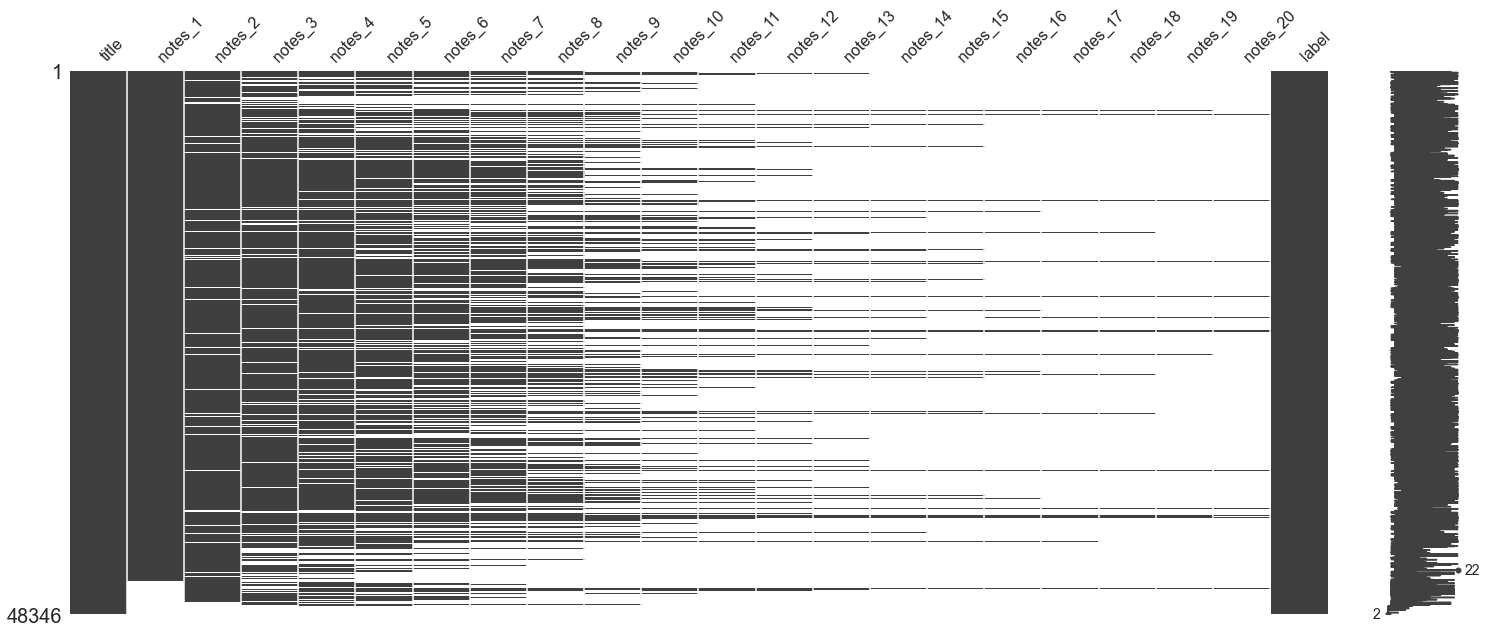

In [109]:
msno.matrix(df.sort_values(by=notes_columns[0:4], ascending=False)); 

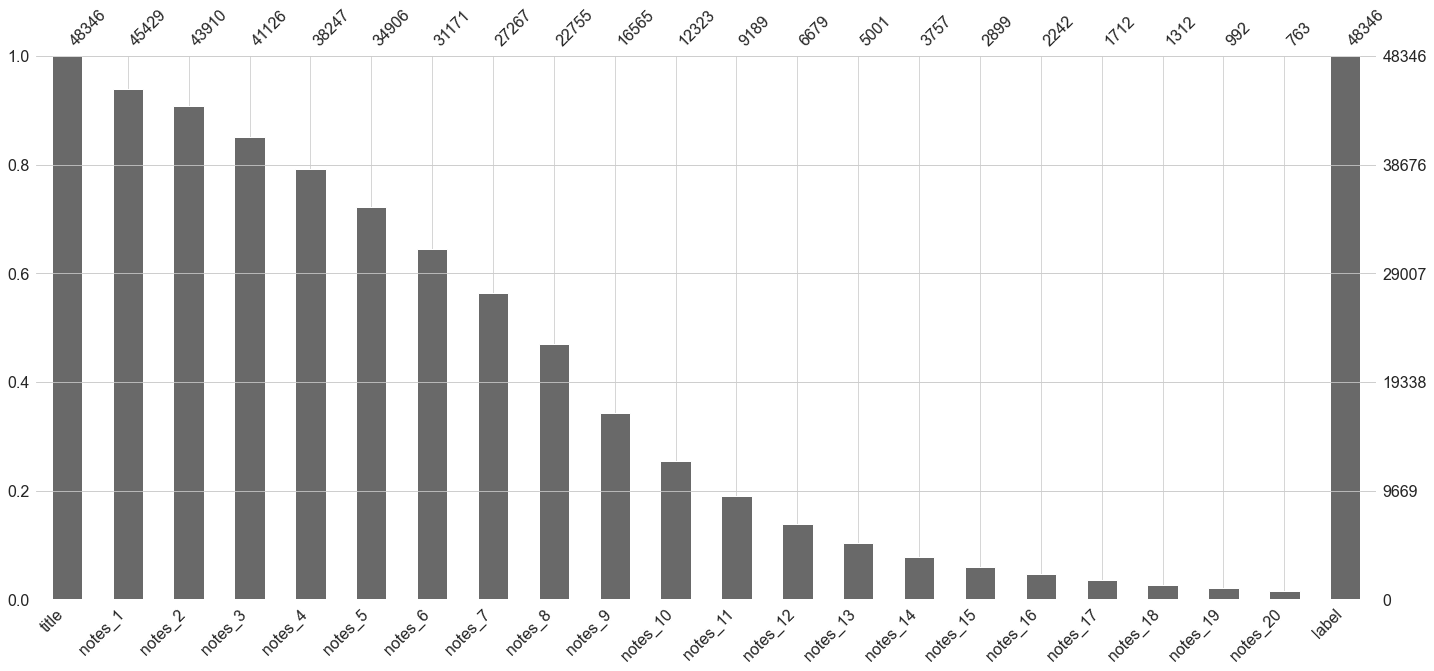

In [110]:
msno.bar(df.sort_values(by=notes_columns[0:4], ascending=False)); 

We have missing values in `notes_1`. But in those cases we have values in subsequent notes columns.

In [111]:
# Are there any perfumes with no notes information?
rows_to_drop = df[df[notes_columns].isnull().sum(axis=1) == 20].index
df.loc[rows_to_drop]

,title,notes_1,notes_2,notes_3,notes_4,notes_5,notes_6,notes_7,notes_8,notes_9,...,notes_12,notes_13,notes_14,notes_15,notes_16,notes_17,notes_18,notes_19,notes_20,label
58,Peau d'Ailleurs Starck for women and men,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unisex
312,Juicy Dessert Jessica Simpson for women,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
420,Himalayan Musk Nemat International for women a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
425,Honeysuckle Vine Olivina Napa Valley for women,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
455,Chewing Gum Pimkie for women,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50740,Nike Urban Musk Nike for men,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unisex
50753,Sequin Nights Victoria's Secret for women,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
50935,North Shore Forever Florals Hawaii for men,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,men
51103,Rose Nuage Pupa for women,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women


We have 602 rows with no relevant information. let's drop them.

In [112]:
df.drop(rows_to_drop, inplace=True)

In [113]:
df[df[notes_columns].isnull().sum(axis=1) == 20]

,title,notes_1,notes_2,notes_3,notes_4,notes_5,notes_6,notes_7,notes_8,notes_9,...,notes_12,notes_13,notes_14,notes_15,notes_16,notes_17,notes_18,notes_19,notes_20,label


Let's do a final check.

In [114]:
# No. of null values
df.isnull().sum().sort_values()

title           0
label           0
notes_1      2225
notes_2      3744
notes_3      6528
notes_4      9407
notes_5     12748
notes_6     16483
notes_7     20387
notes_8     24899
notes_9     31089
notes_10    35331
notes_11    38465
notes_12    40975
notes_13    42653
notes_14    43897
notes_15    44755
notes_16    45412
notes_17    45942
notes_18    46342
notes_19    46662
notes_20    46891
dtype: int64

We do have NULL values in the `notes_` fields. But they are MAR(Missing at Random) values as there are perfumes that may not have too many notes.

The minimum requirement is to have at least one note for a perfume, which we have in our dataset.

### 2.6.4 Check for Duplicates<a id='2.6.4_Check_Duplicates'></a>

Let's check for duplicates based on `title` and `notes` columns.

In [115]:
df[df.duplicated(['title'] + notes_columns)]

,title,notes_1,notes_2,notes_3,notes_4,notes_5,notes_6,notes_7,notes_8,notes_9,...,notes_12,notes_13,notes_14,notes_15,notes_16,notes_17,notes_18,notes_19,notes_20,label
6559,Ghost Pine Lvnea for women and men,Top1Dried Fallen Leaves,Top2Moss,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unisex
9408,Amber Room Thameen for women and men,Top1Turkish Rose,Top2Amber,Top3Spices,Top4Cedar,Top5Coriander,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,men
19878,Blossom TRNP for women and men,Top1Ylang-Ylang,Top2Orange Blossom,Top3White Ginger Lily,Top4Jasmine,Top5Tiare Flower,Top6Amyris,Top7Sandalwood,Top8Amber,Top9Atlas Cedar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,women
23223,Carved Oud Thameen for women and men,Middle0Cedar,Middle1Guaiac Wood,Base0Patchouli,Base1Musk,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,men
36892,Lillà Lillà L'Erbolario for women,Top1Orange,Top2Neroli,Top3Peach,Top4Cardamom,Middle0Lilac,Middle1Violet,Middle2Indian Jasmine,Middle3Labdanum,Middle4Tonka Bean,...,Base2Cedar,Base3White Musk,Base4Amber,NaN,NaN,NaN,NaN,NaN,NaN,women


In [116]:
# drop duplicate records
df.drop_duplicates(subset=['title'] + notes_columns, inplace=True)

In [117]:
df[df.duplicated(['title'] + notes_columns)]

,title,notes_1,notes_2,notes_3,notes_4,notes_5,notes_6,notes_7,notes_8,notes_9,...,notes_12,notes_13,notes_14,notes_15,notes_16,notes_17,notes_18,notes_19,notes_20,label


No duplicates. We are good to go.

## 2.7 Save file<a id='2.7_Save_File'></a>

In [118]:
df.shape

(47649, 22)

Save this to your data directory, separately. Note that you were provided with the data in `raw` and you should be saving derived data in a separate location. This guards against overwriting our original data.

In [119]:
df.to_csv('../data/interim/perfume_labeled.csv', index=False)

## 2.8 Summary<a id='2.8_Summary'></a>

We started off with a dataset of shape (51212, 86) and has now ended up with (47649, 22).

Here are the changes we have made to the dataset from the raw form we received.

1. Dropped columns that are of no interest to this case study.
2. Dropped rows missing `notes_1` and having no notes information.
3. Created Labels based on the votes received from customers.

Finally, we have a labeled dataset and can proceed to do EDA.